In [33]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import nbinom

In [34]:
az.style.use("arviz-darkgrid")
SEED = 7355608

# Poisson and Negative Binomial regression example with offsets

This example is based on the ["Roaches"](https://github.com/avehtari/ROS-Examples/tree/master/Roaches/) example from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/index.html) by Gelman, Hill, and Vehtari.   The example is a count regression model with an offset term. 

The data is the number of roaches caught in 262 apartments.  Some pest control treatment was applied to 158 (treatment=1) of the apartments, and 104 apartments received no treatment (treatment=0).   The other columns in the data are:

- `y`: the number of roaches caught
- `roach1` : the pre-treatment roach level
- `senior` : indicator for whether the appartment is for seniors
- `exposure2` : the number of trap-days (number of traps x number of days).   



In [35]:
roaches = pd.read_csv("data/roaches.csv", index_col=0)
# rescale 
roaches["roach1"] = roaches["roach1"] / 100
roaches.head()


,y,roach1,treatment,senior,exposure2
1,153,3.0800,1,0,0.800000
2,127,3.3125,1,0,0.600000
3,7,0.0167,1,0,1.000000
4,7,0.0300,1,0,1.000000
5,0,0.0200,1,0,1.142857


## Poisson regression



One way to model this is to say that there is some rate of roaches per trap-day , and that the number of roaches caught is a Poisson random variable with a rate that is proportional to the number of trap-days (the *exposure*).    That is:

$$
\begin{align*}
y_i &\sim \text{Poisson}(\text{exposure2}_i \times \rho_i) \\
\log(\rho_i) &= \beta_0 + \beta_1 \text{treatment}_i + \beta_2 \text{roach1}_i + \beta_3 \text{senior}_i
\end{align*}
$$

With a little algebra, we can rewrite this as a generalized linear model:

$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log(\lambda_i) &= \beta_0 + \beta_1 \text{treatment}_i + \beta_2 \text{roach1}_i + \beta_3 \text{senior}_i + \log(\text{exposure2}_i)
\end{align*}
$$

However, we don't want to estimate a coefficient for $\log(\text{exposure2})$, we want to simply add it as an *offset*.   In `bambi` we do this by using the `offset` function in the formula to specify that a term should not be multiplied by a coefficient to estimate and simply added.  The formula for the model is then:

```python
"y ~ roach1 + treatment + senior + offset(log(exposure2))"
```

If you are familiar with R this offset term is the same as the offset term in the `glm` function.

In [36]:

# bambi poisson model
model_1 = bmb.Model("y ~ roach1 + treatment  + senior + offset(log(exposure2))", family = "poisson", data = roaches)
idata_1 = model_1.fit()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, roach1, treatment, senior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [41]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.089,0.022,3.046,3.130,0.000,0.0,3637.0,3558.0,1.0
roach1,0.698,0.009,0.681,0.716,0.000,0.0,3098.0,2512.0,1.0
senior,-0.381,0.034,-0.442,-0.318,0.001,0.0,4252.0,3179.0,1.0
treatment,-0.517,0.025,-0.562,-0.468,0.000,0.0,4004.0,2984.0,1.0


Lets check the posterior predictive distribution for the model.  We plot the log of y to make the results easier to see.

In [42]:
def plot_log_posterior_ppc(model, idata):
    # plot posterior predictive check
    model.predict(idata, kind='response', inplace=True)
    var_name = 'log(y+1)'
    # there is probably a better way
    idata.posterior_predictive[var_name] = np.log(idata.posterior_predictive['y'] + 1)
    idata.observed_data[var_name] = np.log(idata.observed_data['y'] + 1)
    
    return az.plot_ppc(idata, var_names=[var_name])



<Axes: xlabel='log(y+1)'>

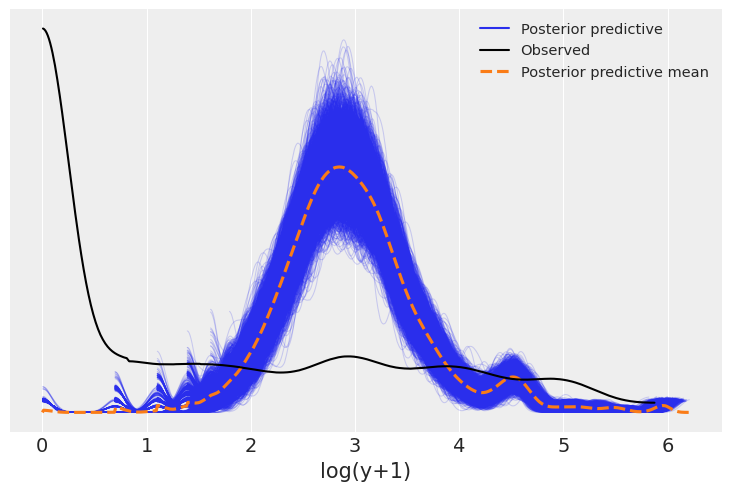

In [43]:
plot_log_posterior_ppc(model_1, idata_1)

In [44]:
# check number of zeros in y

def check_zeros(idata):
    # flatten over chains:
    sampled_zeros = (idata.posterior_predictive["y"]==0).mean(("__obs__")).values.flatten()
    print(f"Fraction of zeros in the observed data: {np.mean(roaches['y']==0)}")
    print(f"Fraction of zeros in the posterior predictive check: {np.mean(sampled_zeros)}")
    print(f" 80% CI: {np.percentile(sampled_zeros, [10, 90])}")

check_zeros(idata_1)
 

Fraction of zeros in the observed data: 0.35877862595419846
Fraction of zeros in the posterior predictive check: 0.0006803435114503817
 80% CI: [0.         0.00381679]


This is not a very good model for this data, we are drastically underpredicting the number of small counts. This suggests we try an overdispersed model like the negative binomial.   

## Negative Binomial Fit

In [45]:
# bambi poisson model
model_2 = bmb.Model("y ~ roach1 + treatment  + senior + offset(log(exposure2))", family = "negativebinomial", data = roaches)
idata_2 = model_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, roach1, treatment, senior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [46]:
az.summary(idata_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.849,0.235,2.411,3.275,0.003,0.002,5038.0,2971.0,1.0
alpha,0.273,0.026,0.225,0.324,0.000,0.000,5261.0,3595.0,1.0
roach1,1.321,0.254,0.851,1.796,0.004,0.003,4106.0,3317.0,1.0
senior,-0.329,0.263,-0.821,0.176,0.004,0.003,4147.0,3470.0,1.0
treatment,-0.784,0.249,-1.296,-0.353,0.004,0.003,4731.0,3091.0,1.0


<Axes: xlabel='log(y+1)'>

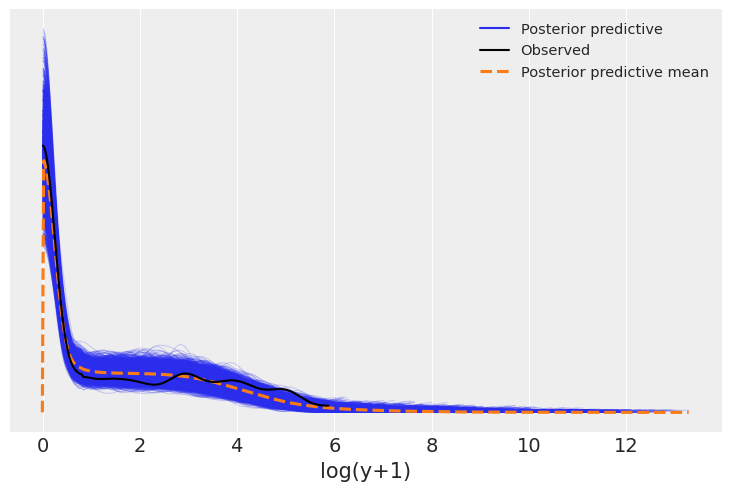

In [47]:
plot_log_posterior_ppc(model_2, idata_2)

In [48]:

check_zeros(idata_2)

Fraction of zeros in the observed data: 0.35877862595419846
Fraction of zeros in the posterior predictive check: 0.33822614503816795
 80% CI: [0.28625954 0.38969466]


The negative binomial distribution fit works much better, predicting the number of zeros consistent with the observed data. *Regression and Other Stories* introduces a further improvement by introducing a zero-inflated regression later in the chapter, but I will not persue that here, after all the point of this example is to illustrate the use of offsets. 



## PYMC equivalent model

The model behind the scenes looks like this for the Poission model.

In [49]:
pymc_model = model_1.backend
pymc_model.model

Intercept ~ Normal(0, 4.52)
   roach1 ~ Normal(0, 3.33)
treatment ~ Normal(0, 5.11)
   senior ~ Normal(0, 5.43)
       mu ~ Deterministic(f(senior, treatment, roach1, Intercept))
        y ~ Poisson(mu)


Let's look at the equivalent (Poisson) model in PYMC:   

In [50]:
# recreate the model using pymc
with pm.Model() as model_pymc:
    # priors
    alpha = pm.Normal("Intercept", mu=0, sigma=4.5)
    beta_roach1 = pm.Normal("beta_roach1", mu=0, sigma=3.3)
    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=5.11)
    beta_senior = pm.Normal("beta_senior", mu=0, sigma=5.43)
    
    # likelihood
    mu = pm.math.exp(alpha + beta_roach1 * roaches["roach1"] +
                             beta_treatment * roaches["treatment"] +
                             beta_senior * roaches["senior"] +
                             pm.math.log(roaches["exposure2"])) # no beta for exposure2 
    y = pm.Poisson("y", mu=mu, observed=roaches["y"])

    idata_pymc = pm.sample(1000)  

az.summary(idata_pymc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_roach1, beta_treatment, beta_senior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.089,0.022,3.045,3.126,0.000,0.0,2697.0,2757.0,1.0
beta_roach1,0.698,0.009,0.682,0.716,0.000,0.0,3008.0,3014.0,1.0
beta_senior,-0.379,0.034,-0.443,-0.317,0.001,0.0,3361.0,2736.0,1.0
beta_treatment,-0.517,0.025,-0.564,-0.470,0.000,0.0,3116.0,2926.0,1.0


In this model (`model_pymc`) we have the equivalent Poisson regression with everything explicit to illustrate what the 'offset' function is doing. It simply makes it possible to express a term like this in the `formulae` string in a `bambi` model.

 